# Fashion-MNIST Classifier
**P2963116**

### Project Brief
1. Experience building and training Artificial Neural Networks (ANNs) for classification problems.
2. Experience preprocessing image datasets.
3. Experience implementing and testing neural networks in Python using PyTorch/TensorFlow.
4. Experience comparing different neural architectures (ANN vs. CNN).

The goal of this project is to create a working classifier for use on the Fashion-MNIST dataset and to compare different architectures' performance.
I will be using *PyTorch* primarily, but also *SciKit-Learn* and *Seaborn* to create my project and display output data.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import (
    ToTensor,
    Normalize,
    Compose,
    RandomAffine,
    RandomHorizontalFlip,
)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import seaborn as sns
import pandas as pd
from torchsummary import summary
import random
import numpy as np

# Ensure reproducability
random.seed(9)
torch.manual_seed(9)

# Various Preamble
sns.set_theme()
print("PyTorch version:", torch.__version__)
print("PyTorch working with CUDA:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


### Data import and pre-processing
Using Torchvision's datasets module we can easily import our dataset. It also comes with the built-in method 'transform' allowing us to preprocess our data. In this case we use the ToTensor method and Normalize to store the images correctly and normalise pixel values. We will also reserve a random 20% subset of the training data for use in validation at each training step.

Additionally the DataLoader allows us to automatically batch and shuffle our training and test datasets should we wish. In this case we only really need to shuffle the training data as we will not be adjusting weights using the test dataset.

I have also added a couple of asserts to ensure our data was loaded correctly (through checking the shape). In this case there should be no issues.

In [2]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = [
    "T-Shirt",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle Boot",
]

# Data pre-processing transformations
transforms = Compose([ToTensor(), Normalize(mean=0.5, std=0.5)])

# Initialise data
training_data = datasets.FashionMNIST(
    root="data",
    train=True, 
    download=True, 
    transform=transforms
)

test_data = datasets.FashionMNIST(
    root="data", 
    train=False, 
    download=True, 
    transform=transforms 
)

# Train on 80%, reserve remainder for validation
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
train_subset, val_subset = random_split(training_data, [train_size, val_size])

# Batch Size (default = 64)
batch_size = 64

# Load the data with automatic shuffling for training/validation
train_loader = DataLoader(train_subset, batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False, pin_memory=True)

train_images, train_labels = next(iter(train_loader))
val_images, val_labels = next(iter(val_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size, 1, 28, 28])
assert train_images.shape == train_expected_size

val_expected_size = torch.Size([batch_size, 1, 28, 28])
assert val_images.shape == val_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

### Example Image with label
Here we take the first image in one of our training batches and display using MatPlotLib, the title is its associated label.

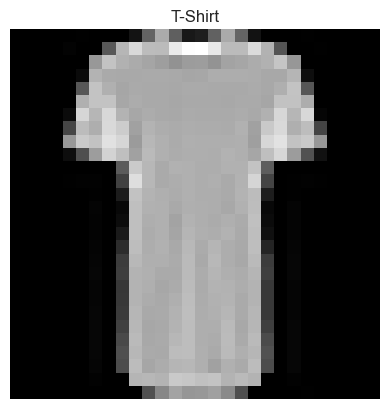

In [3]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis("off")
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap("gray")
plt.title(label)
plt.show()

## Building our ANN
Using PyTorch it is very easy to create a simple network using global variables and nn.Sequential, however using a class will give us some flexibility in the width of our model while allowing for non-destructive testing to occur while optimising our network architecture.
Furthermore, for the sake of comparison there exists 2 possible architectures within this class, one which contains dropout and another which does not. Initially, the linear model was tested using no dropout however as we will see below, we later implemented dropout to prevent overfitting from occuring during the training process.
Each class we create inherits from the nn.Module class and requires an init function as well as a forward function which defines the forward pass of the network.

### Init
In the init function we first inherit everything from nn.Module and then specify our ReLU stack. This is defined using a series of linear perceptrons and ReLU activation layers. In the  case of using dropout, we also add dropout layers into the sequence between each layer. Additionally we also specify a flatten method which enables us to input the raw tensor data directly from the DataLoader without having to store the flattened image tensors as a global variable.
For more information on the arguments see the comments in the code itself.

### Forward
This is very simple, it applies a forward pass to our model where we then apply Logarithmic Softmax to the output (as this is a classification task).

In [4]:
# Define a class for an MLP (dropout optional)
class MultilayerPerceptron(nn.Module):
    def __init__(
        self,
        hidden1,
        hidden2,
        hidden3,
        in_features=28 * 28,
        out_features=10,
        use_dropout=False,
        dropout_prob=0.2,
    ):
        """
        Multi-Layer Perceptron with specifiable hidden layer widths and optional use of dropout
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
            use_dropout (bool/optional): enable dropout
            dropout_prob (float/option): specify dropout probability. (default = 0.2)
        """
        super().__init__()
        self.flatten = nn.Flatten()
        if use_dropout:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.BatchNorm1d(hidden1),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden1, hidden2),
                nn.BatchNorm1d(hidden2),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden2, hidden3),
                nn.BatchNorm1d(hidden3),
                nn.ReLU(),
                nn.Dropout(dropout_prob),
                nn.Linear(hidden3, out_features),
            )
        else:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_features),
            )

    def forward(self, x):
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.log_softmax(output, dim=1)
        return output

## CNN Architecture
Much the same as with the ANN, we create a class to define our CNN. This also inherits from nn.Module. Unlike the ANN, we do not need to flatten our input data until we have passed it through the convolution layers.

### Init
Once again we inherit everything from the parent class nn.Module. Next we create a sequence of 2D-Convolution and MaxPool layers, a flatten method (identical to our ANN class) and a sequence of dense layers using ReLU as the activation functions. As a result of testing seen later in the notebook, Dropout and Batch Norm layers are also added in the dense layers.

### Forward
We define the forward pass by sending our input through the convolution stack before flattening this output. The flattened tensor is then, just as with the ANN sent through the dense layers before Log Softmax is applied and our output is returned.

In [75]:
# Define our CNN Architecture
class CNNNetwork(nn.Module):
    """
    Defines a simple Convolutional Neural Network with 2 convolution layers and 2 instances of MaxPooling. Dropout p=0.2 in the dense layers.
    Args:
        in_channels (int): number of input channels. 1 for greyscale, 3 for rgb images etc.
        out_channels (int): number of classes
        filters1 (int): number of filters in convolution block 1
        filters2 (int): number of filters in convolution block 2
        kernel1 (int/tuple): kernel size in conv block 1
        kernel2 (int/tuple): kernel size in conv block 2
        stride1 (int): stride for conv block 1
        stride2 (int): stride for conv block 2
    """

    def __init__(
        self,
        in_channels=1,
        out_channels=10,
        filters1=64,
        filters2=128,
        kernel1=3,
        kernel2=3,
        stride1=1,
        stride2=1,
    ):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, filters1, kernel1, stride1, 1)
        self.bn1 = nn.BatchNorm2d(filters1)
        self.conv2 = nn.Conv2d(filters1, filters1, kernel1, stride1, 1)
        self.bn2 = nn.BatchNorm2d(filters1)
        self.max = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(filters1, filters2, kernel2, stride2, 1)
        self.bn3 = nn.BatchNorm2d(filters2)
        self.conv4 = nn.Conv2d(filters2, filters2, kernel2, stride2, 1)
        self.bn4 = nn.BatchNorm2d(filters2)
        self.gavgpool =     nn.AdaptiveAvgPool2d(1)
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(filters2, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, out_channels),
        )

    def forward(self, x):
        self.feature_map1 = F.relu(self.conv1(x))
        output = F.dropout2d(self.bn1(self.feature_map1),p=0.2)
        self.feature_map2 = F.relu(self.conv2(output))
        output = F.dropout2d(self.bn2(self.feature_map2),p=0.2)
        output = self.max(output)
        self.feature_map3 = F.relu(self.conv3(output))
        output = F.dropout2d(self.bn3(self.feature_map3),p=0.2)
        self.feature_map4 = F.relu(self.conv4(output))
        output = F.dropout2d(self.bn4(self.feature_map4),p=0.2)
        output = self.max(output)
        output = self.gavgpool(output)
        output = self.flatten(output)
        output = self.dense(output)
        output = F.log_softmax(output, dim=1)
        return output

## Train/Test Functions
Since we are defining multiple models, it would be nice to just write the code to train and test once, hence we will use a function here instead of global variables.
### Train
This function outlines the training process in any given epoch. We first enable training mode using the train() method, calculate the muber of batches and set our total loss to 0 (for a specified criterion).
Now we iterate over all the items in our dataset using a for loop.
We zero the gradient calculations before performing a forward pass of our model and calculating the loss. We then backpropagate using the backward() method and use the step() method to update the training parameters based on our optimiser. We finally add the training loss for every item before calculating the mean loss per batch. 
This value is then printed and returned.
### Test
Similar to the train function, however we need not specify an optimiser as we will not be updating any weights.
The eval() method sets our model to evaluation mode, meaning parameters will not be updated as we iterate over the data. Since we are going to be recording accuracy we need both the number of batches and number of samples for our given dataloader. 
We perform the forward pass of our model with no gradients calculated but this time we also want to check if the prediction is correct so we can calculate the accuracy of the model.

In [6]:
# Define a train and test function for use with our models
def train(dataloader, model, loss_fn, optimizer):
    """
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optimizer: optimiser used for gradient parameter adjustment
    Returns:
        train_loss (float): Average loss on dataloader
    """
    model.train()
    num_batch = len(dataloader)
    train_loss = 0.0
    for X, label in dataloader:
        X, label = X.to(device), label.to(device)
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    return train_loss


def test(dataloader, model, loss_fn):
    """
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function
    Returns:
        test_loss (float): Average loss on dataloader
        accuracy (float): Accuracy on dataloader
    """
    model.eval()
    num_batch = len(dataloader)
    samples = len(dataloader.dataset)
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X, label in dataloader:
            X, label = X.to(device), label.to(device)
            pred = model(X)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            pred = pred.argmax(1)
            correct += (pred == label).type(torch.float).sum().item()

    test_loss /= num_batch
    accuracy = correct / samples * 100
    return test_loss, accuracy

## Combining train and test
Finally, we want to call a single function which can iterate our training and validation datasets over a specified number of epochs. To track our losses and accuracy we store these values in a list where each item in loss_hist is itself a list containing the training loss and the test loss, while accuracy_hist contains the accuracy of the model on the validation set after each epoch. After all epochs we pass the training set through the model also and store the test accuracy. We finally create a dictionary which contains all the history data and return it along with the test accuracy for use in plotting our results.

In [7]:
# Train/test loop combined, we will use accuracy as our primary metric
def run(train_loader, val_loader, test_loader, model, epochs, loss_fn, optimizer):
    """
    Runs our model train and test loop for a specified number of epochs
    Args:
        rain_loader (Dataloader(data)): Training data
        val_loader (Dataloader(data)): Validation data
        test_loader (Dataloader(data)): Test data
        model (MultilayerPerceptron): Model
        epochs (int): Number of epochs
    Returns:
        history (dict): Dictionary with keys, epochs, train_loss, val_loss, accuracy_hist. Values are lists of length range(epochs)
        test_accuracy (float): Accuracy on test loader
    """
    train_loss_hist = []
    val_loss_hist = []
    accuracy_hist = []

    for e in range(epochs):
        print(f"Epoch {e + 1}/{epochs}")
        train_loss = train(train_loader, model, loss_fn, optimizer)
        print(f"Training loss = {train_loss:>5f}")
        val_loss, val_accuracy = test(val_loader, model, loss_fn)
        print(f"Validation loss = {val_loss:>5f} (Accuracy = {val_accuracy:.2f}%)")
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        accuracy_hist.append(val_accuracy)

    # Return test acc for final epoch
    print("Switching to test set:")
    _, test_accuracy = test(test_loader, model, loss_fn)
    print(f"Final accuracy on test set: {test_accuracy:.2f}%")
    history = {
        "epoch": range(epochs),
        "train_loss": train_loss_hist,
        "val_loss": val_loss_hist,
        "accuracy_hist": accuracy_hist,
    }
    return history, test_accuracy

## Data preparation
Similarly, since we are going to be reusing some code I will write a short function for preparing our data for plotting using seaborn and pandas. The DataFrame structure is very useful for storing our data such that we only need to call a single variable for different plots. To smooth out some of the plots I have decided that it would be of use to calculate rolling averages for the validation loss and accuracy history to use in comparison plots.

In [ ]:
def PrepareData(result):
    """
    Takes our outputs from run and prepares it for plotting.
    Calculates a 3 epoch rolling average validation loss and 5 epoch rolling average validation accuracy
    Args:
        result (dict): Dictionary output from run function
    Returns:
        data (pd.DataFrame): Pandas dataframe for use with seaborn
    """
    data = pd.DataFrame(result)
    data["val_rolling"] = data.val_loss.rolling(3).mean()
    data["acc_rolling"] = data.accuracy_hist.rolling(5).mean()
    return data

## Confusion matrix
In addition, it is nice to visualise the confusion matrix for our models so we can easily identify potential shortcomings of our model, and also debug any potential issues. For example, I was consistently facing an issue where my model was unable to produce any predictions for index 6: "Shirt", caused by a bottleneck in network width. Without the use of the visualisation it was difficult to understand why my model had limited accuracy. As such visualising the results like this was very impactful in diagnosing issues with my models.

In [9]:
# Confusion matrix plotter
def ConfMatDisplay(dataloader, model):
    """
    Create a confusion matrix and plot
    Args:
        dataloader (Dataloader(data)): Option to use a custom dataloader for test data
        model (ANN/CNN): Model
    """
    predictions = []
    labels = []
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = pred.argmax(1)
        predictions += pred.tolist()
        labels += label.tolist()
    cm = confusion_matrix(labels, predictions)
    disp = ConfusionMatrixDisplay(cm, display_labels=data_labels)
    disp.plot(xticks_rotation="vertical", cmap="inferno")
    plt.grid(False)
    plt.show()

## Custom Metrics

In [95]:
def CustomMetrics(dataloader,model,type):
    predictions = []
    labels = []
    typelist = np.array([type for _ in range(10)])
    metrics = {}
    for data, label in dataloader:
        data, label = data.to(device), label.to(device)
        pred = model(data)
        pred = pred.argmax(1)
        predictions += pred.tolist()
        labels += label.tolist()
        typelist += type
    metrics['precision'], metrics['recall'], metrics['f1_score'], _ = precision_recall_fscore_support(labels,predictions,average=None)
    metrics['type'] = typelist
    metrics['index'] = range(10)
    metrics = pd.DataFrame(metrics)
    return metrics

## The first model
Initially I had opted to use layer widths of 512,256,128 (as was used in the lab material), but as mentioned above, it led to issues with the model being unable to predict an entire category of label. Upon changing to values which are divisors of our input lengths (392,196,98), the performance of the model jumped with an increase in accuracy of around 10%. There is still a potential bottleneck in the output layer as we go from 98 inputs to just 10 outputs so further testing may show that a narrower model (or an addition layer with fewer neurons) will increase performance.
### Hyperparameters
To start we will use the fairly standard value of 0.001 as our learn rate and I decided on 30 epochs for training as it is ample time to highlight any major issues that occur during training while not taking too long to compute on my RTX 3070ti (around 5 minutes for the ANNs and 12 minutes for the CNN).
### Loss function and Optimiser Choice
We will be using Negative Log Likelihood as our loss function and Adam as our optimiser. We can also use Stochastic Gradient Descent (SGD), another good choice for classifier tasks and something we will see used in evaluation graphs below.

In [11]:
# Initialise ANN and show structure
ann_model = MultilayerPerceptron(392, 196, 98).to(device)
summary(ann_model, input_size=(1, 28, 28))

# Hyperparameters
learn_rate = 1e-3
epochs = 30

# initialise loss function and optimiser
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=learn_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
              ReLU-3                  [-1, 392]               0
            Linear-4                  [-1, 196]          77,028
              ReLU-5                  [-1, 196]               0
            Linear-6                   [-1, 98]          19,306
              ReLU-7                   [-1, 98]               0
            Linear-8                   [-1, 10]             990
Total params: 405,044
Trainable params: 405,044
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.55
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [12]:
# Train and test the model based on hyperparameters
ann_hist, ann_test_accuracy = run(train_loader, val_loader, test_loader, ann_model, epochs, loss_fn, optimizer)

Epoch 1/30
Training loss = 0.536082
Validation loss = 0.441378 (Accuracy = 83.99%)
Epoch 2/30
Training loss = 0.389060
Validation loss = 0.366423 (Accuracy = 86.94%)
Epoch 3/30
Training loss = 0.349035
Validation loss = 0.352731 (Accuracy = 87.15%)
Epoch 4/30
Training loss = 0.318947
Validation loss = 0.337059 (Accuracy = 87.65%)
Epoch 5/30
Training loss = 0.299579
Validation loss = 0.332648 (Accuracy = 87.56%)
Epoch 6/30
Training loss = 0.281488
Validation loss = 0.346303 (Accuracy = 87.30%)
Epoch 7/30
Training loss = 0.269033
Validation loss = 0.317683 (Accuracy = 88.58%)
Epoch 8/30
Training loss = 0.252245
Validation loss = 0.329020 (Accuracy = 88.49%)
Epoch 9/30
Training loss = 0.239632
Validation loss = 0.297482 (Accuracy = 89.17%)
Epoch 10/30
Training loss = 0.229783
Validation loss = 0.318011 (Accuracy = 89.03%)
Epoch 11/30
Training loss = 0.219730
Validation loss = 0.317166 (Accuracy = 88.93%)
Epoch 12/30
Training loss = 0.207093
Validation loss = 0.307475 (Accuracy = 89.29%)
E

### Plotting Losses
From the above output it is useful to visualise the loss over time of our model to diagnose any potential issues. As we will see below, we see some significant overfitting occur as the validation loss begins to diverge after around 10 epochs. We will work to mitigate this in a number of ways as discussed below.

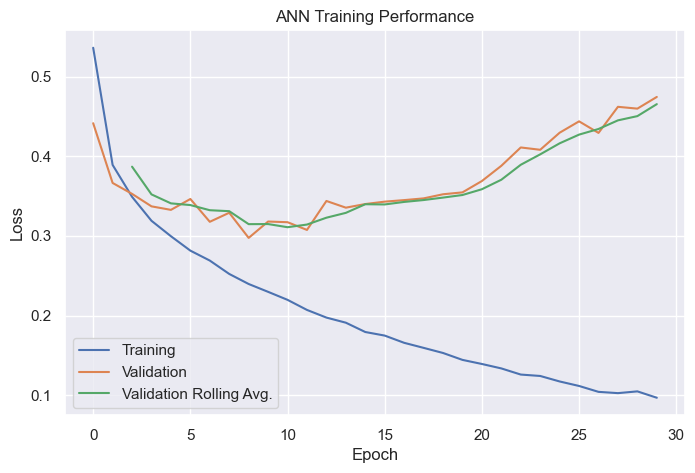

In [13]:
ann_data = PrepareData(ann_hist)
# Plot relevant history
plt.figure(figsize=(8, 5))
sns.lineplot(data=ann_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=ann_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(data=ann_data, x="epoch", y="val_rolling", label="Validation Rolling Avg.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ANN Training Performance")
plt.show()

### Confusion Matrix
Ideally we would have a value as close to 1000 as possible on the diagonal axis however what we can see here is there is a number of areas where the model fails to correctly classify the inputs. Intuitively this might make sense as the common erros are between categories such as 'Shirt', 'Tshirt', 'Coat' and 'Pullover,' which when considering the size of our input images seems like a reasonable error that even a human might make due to lack of detail.

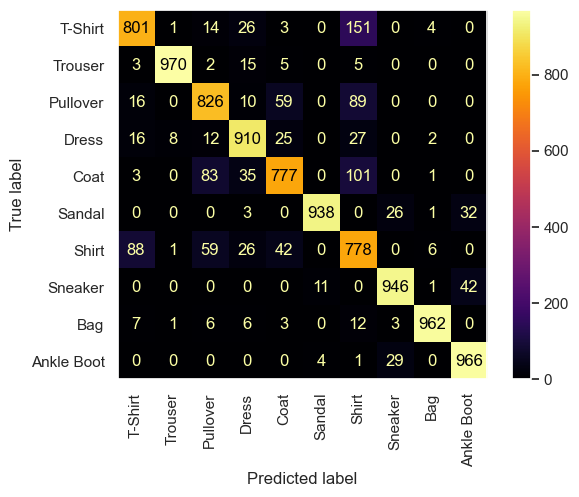

In [14]:
# Visualise confusion matrix for our first model
ConfMatDisplay(test_loader, ann_model)

## Mitigating Overfitting
Initial findings suggest a significant amount of overfitting occured during the training process. There is a number of ways we can deal with this, which we will implement in due course.
### Dropout
Dropout involves randomly disabling connections between layers at a fixed probability, in this case we will use p=0.2. Note that this only occurs during training as when we apply the model.eval() method, it disables dropout layers. The goal of this is to try and prevent the model from overoptimising on the training dataset, limiting its ability to predict unseen data accurately.
### Batch Normalisation
A further method we can use is through Batch Normalisation (BatchNorm). This aims to improve the stability of training by normalising each batch of input data, essentially performing a rescaling of inputs, much the same as we did by normalising the images when preprocessing our data.
## Modified Model
Considering the above, we will initalise a new model with the above two ideas implemented. For the sake of comparison all the other features are equal.

In [15]:
# Define a new ANN with dropout for comparison
ann_dropout = MultilayerPerceptron(392, 196, 98, use_dropout=True).to(device)
summary(ann_dropout, input_size=(1, 28, 28))
dropout_optimizer = torch.optim.Adam(ann_dropout.parameters(), lr=learn_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 392]         307,720
       BatchNorm1d-3                  [-1, 392]             784
              ReLU-4                  [-1, 392]               0
           Dropout-5                  [-1, 392]               0
            Linear-6                  [-1, 196]          77,028
       BatchNorm1d-7                  [-1, 196]             392
              ReLU-8                  [-1, 196]               0
           Dropout-9                  [-1, 196]               0
           Linear-10                   [-1, 98]          19,306
      BatchNorm1d-11                   [-1, 98]             196
             ReLU-12                   [-1, 98]               0
          Dropout-13                   [-1, 98]               0
           Linear-14                   

We repeat the same process for training the model.

In [16]:
# Train and test
dropout_hist, dropout_test_accuracy = run(train_loader,val_loader,test_loader,ann_dropout,epochs,loss_fn,dropout_optimizer)

Epoch 1/30
Training loss = 0.547824
Validation loss = 0.382705 (Accuracy = 86.02%)
Epoch 2/30
Training loss = 0.408798
Validation loss = 0.364257 (Accuracy = 86.46%)
Epoch 3/30
Training loss = 0.370748
Validation loss = 0.323746 (Accuracy = 88.12%)
Epoch 4/30
Training loss = 0.345601
Validation loss = 0.318896 (Accuracy = 88.08%)
Epoch 5/30
Training loss = 0.321779
Validation loss = 0.307249 (Accuracy = 88.66%)
Epoch 6/30
Training loss = 0.309179
Validation loss = 0.307229 (Accuracy = 88.72%)
Epoch 7/30
Training loss = 0.301318
Validation loss = 0.292686 (Accuracy = 89.48%)
Epoch 8/30
Training loss = 0.282496
Validation loss = 0.295039 (Accuracy = 89.28%)
Epoch 9/30
Training loss = 0.273557
Validation loss = 0.280637 (Accuracy = 89.84%)
Epoch 10/30
Training loss = 0.259834
Validation loss = 0.297135 (Accuracy = 89.25%)
Epoch 11/30
Training loss = 0.251945
Validation loss = 0.269996 (Accuracy = 90.28%)
Epoch 12/30
Training loss = 0.245726
Validation loss = 0.287777 (Accuracy = 90.06%)
E

What we immediately notice from the outputs of our train/test functions is the loss values are much closer together and we only begin to see the impact of overfitting towards later epochs. What this does fully mitigate is the loss on the validation set diverging entirely so the model no longer becomes more incorrect with further training (at least  from our chosen epoch count). We can see a clear visual representation of this in the plot below:
### Early Stopping
What we might see now, especially as the validation loss essentially flatlines after around 15 epochs is that it might be beneficial to implement early stopping since the model doesn't noticably improve in performance on unseen data beyond this point.

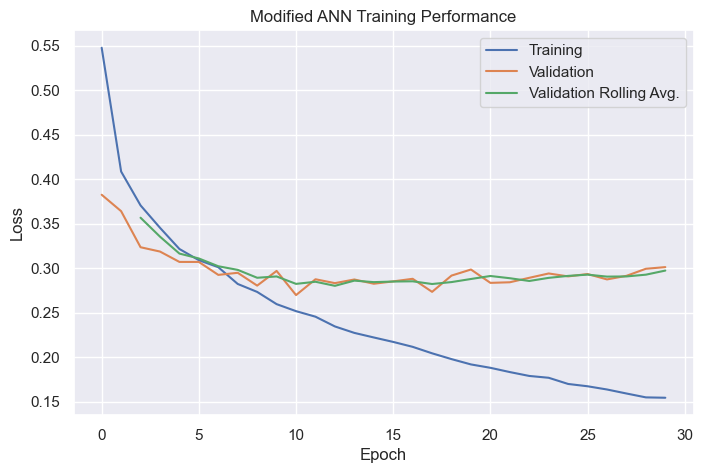

In [17]:
dropout_data = PrepareData(dropout_hist)

# Plot relevant history
plt.figure(figsize=(8, 5))
sns.lineplot(data=dropout_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=dropout_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(
    data=dropout_data, x="epoch", y="val_rolling", label="Validation Rolling Avg."
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Modified ANN Training Performance")
plt.show()

### Confusion Matrix
Test results are quite similar however it is still good to plot this for comparison with the original model, and in this instance there appears to be some noticable performance improvements of around 1-2% over the basic implementation.

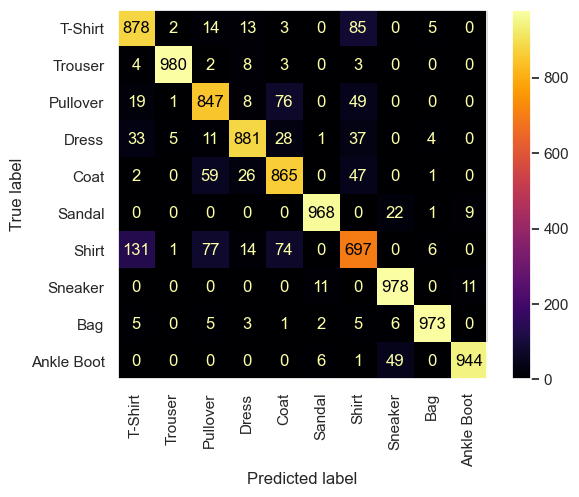

In [18]:
# Visualise confusion matrix
ConfMatDisplay(test_loader, ann_dropout)

## Visualising Model Output
Now that we have a decent idea of 'what works' with respect to our ANN, it would be nice to visualise an example with the respective probabilities.

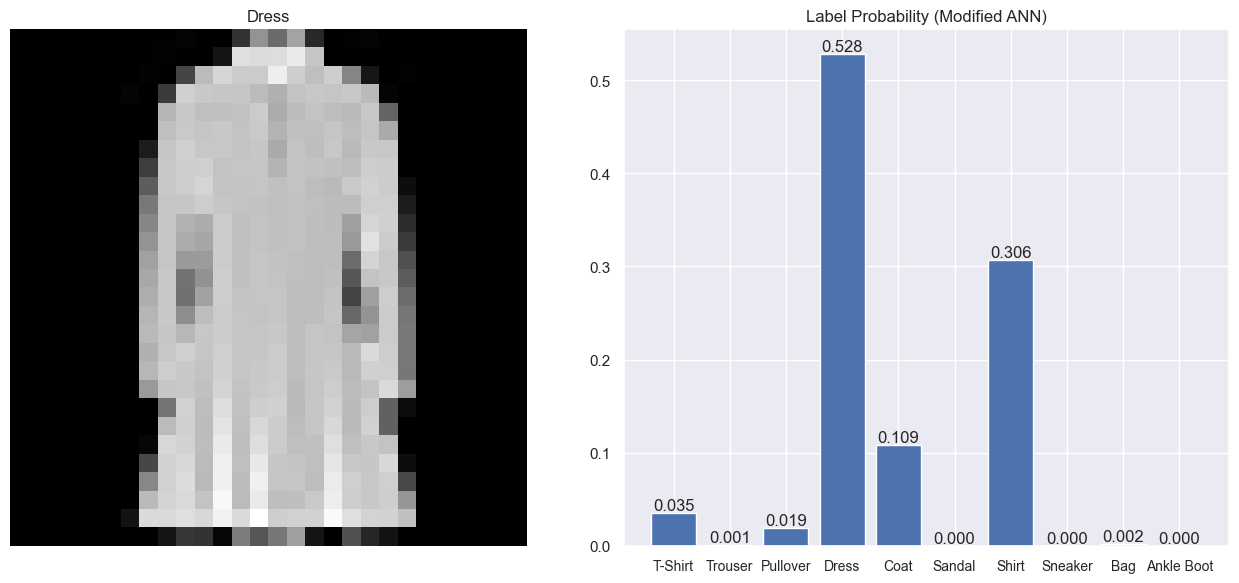

In [19]:
# Select an example (we choose a specific index since test data is unshuffled and also to show a split probability output)
idx = 29
test_image, test_label = test_images[idx].to(device), test_labels[idx].to(device)
prob = torch.exp(ann_dropout(test_image))

# Subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 6))
axes[0].axis("off")
axes[0].imshow(test_images[idx].cpu().numpy().squeeze())
axes[0].set_title(data_labels[test_label.item()])
prob_dist = axes[1].bar(range(10), prob.detach().cpu().numpy().squeeze())
axes[1].set_xticks(range(10))
axes[1].set_xticklabels(data_labels, size="small")
axes[1].set_title("Label Probability (Modified ANN)")
axes[1].bar_label(prob_dist, fmt="{:.3f}")
plt.set_cmap("gray")
plt.tight_layout()

## Optimiser Choice
We have used Adam for both of our models thusfar, however for the sake of comparison let us compare the impact of different optimisers on model performance. We will now create a copy of our existing modified ANN model, but try a few variations using SGD, RMSProp and Adagrad.

In [20]:
# Define various models based on different optimisers
ann_SGD = MultilayerPerceptron(392, 196, 98, use_dropout=True).to(device)
SGD_optimizer = torch.optim.SGD(ann_SGD.parameters(), lr=learn_rate, momentum=0.9)
ann_RMS = MultilayerPerceptron(392, 196, 98, use_dropout=True).to(device)
RMS_optimizer = torch.optim.RMSprop(ann_RMS.parameters(), lr=learn_rate)
ann_adagrad = MultilayerPerceptron(392, 196, 98, use_dropout=True).to(device)
adagrad_optimizer = torch.optim.Adagrad(ann_adagrad.parameters(), lr=learn_rate)

In [21]:
# Train and test each
SGD_hist, SGD_test_accuracy = run(train_loader, val_loader, test_loader, ann_SGD, epochs, loss_fn, SGD_optimizer)
RMS_hist, RMS_test_accuracy = run(train_loader, val_loader, test_loader, ann_RMS, epochs, loss_fn, RMS_optimizer)
adagrad_hist, adagrad_test_accuracy = run(train_loader,val_loader,test_loader,ann_adagrad,epochs,loss_fn,adagrad_optimizer)

Epoch 1/30
Training loss = 0.842891
Validation loss = 0.459756 (Accuracy = 84.54%)
Epoch 2/30
Training loss = 0.505279
Validation loss = 0.385320 (Accuracy = 86.32%)
Epoch 3/30
Training loss = 0.442942
Validation loss = 0.351362 (Accuracy = 87.37%)
Epoch 4/30
Training loss = 0.408576
Validation loss = 0.334923 (Accuracy = 87.77%)
Epoch 5/30
Training loss = 0.388611
Validation loss = 0.326497 (Accuracy = 88.22%)
Epoch 6/30
Training loss = 0.370655
Validation loss = 0.314688 (Accuracy = 88.59%)
Epoch 7/30
Training loss = 0.352000
Validation loss = 0.309853 (Accuracy = 88.72%)
Epoch 8/30
Training loss = 0.340567
Validation loss = 0.302948 (Accuracy = 88.97%)
Epoch 9/30
Training loss = 0.332998
Validation loss = 0.300623 (Accuracy = 89.03%)
Epoch 10/30
Training loss = 0.321658
Validation loss = 0.299136 (Accuracy = 89.22%)
Epoch 11/30
Training loss = 0.311595
Validation loss = 0.293029 (Accuracy = 89.17%)
Epoch 12/30
Training loss = 0.306663
Validation loss = 0.290017 (Accuracy = 89.68%)
E

### Observations
Immediate observations suggest that both Adam and RMSProp produce lower overall loss across both datasets, but especially on the training set suggesting it could be 'better' than SGD and Adagrad. Adagrad is particularly slow at converging, showing that training and validation loss have only just converged by 30 epochs, compared to this occuring at around 5-10 epochs in the case of the other 3. With that in mind Adagrad is probably not the right choice for us to use.
To fully decide it may be a good idea to look into our other evaluation metrics to determine which is the best choice first but Adam still seems to be a strong contender at this point. It is also worth noting that the other optimisers may work better with adjusted hyperparameters, something we could tune using libraries such as Optuna and RayTune, however this may require some large adjustments to my train/test functions.

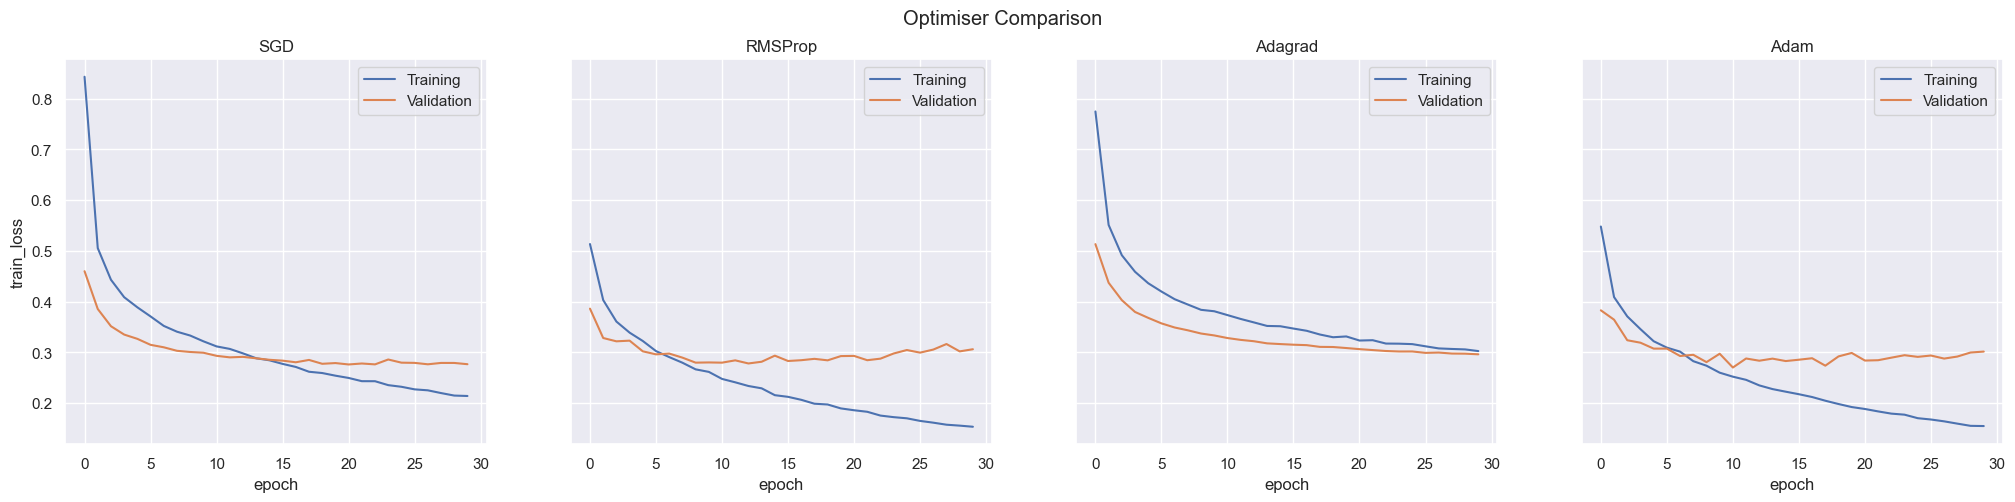

In [22]:
# Prepare data
sgd_data = PrepareData(SGD_hist)
rms_data = PrepareData(RMS_hist)
adagrad_data = PrepareData(adagrad_hist)

# Create subplots for each optimiser type
fig2, axes2 = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(25, 5))
sns.lineplot(ax=axes2[0], data=sgd_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(ax=axes2[0], data=sgd_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(ax=axes2[1], data=rms_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(ax=axes2[1], data=rms_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(
    ax=axes2[2], data=adagrad_data, x="epoch", y="train_loss", label="Training"
)
sns.lineplot(
    ax=axes2[2], data=adagrad_data, x="epoch", y="val_loss", label="Validation"
)
sns.lineplot(
    ax=axes2[3], data=dropout_data, x="epoch", y="train_loss", label="Training"
)
sns.lineplot(
    ax=axes2[3], data=dropout_data, x="epoch", y="val_loss", label="Validation"
)
axes2[0].set_title("SGD")
axes2[1].set_title("RMSProp")
axes2[2].set_title("Adagrad")
axes2[3].set_title("Adam")
plt.suptitle("Optimiser Comparison")
plt.show()

### Evaluation Metric Comparison
Looking at accuracy alone, it is clear to see that Adam produces the best performing model (note: training has been repeated multiple times to ensure this result) and as such will probably mean it remains our optimiser of choice moving forward with the CNN.

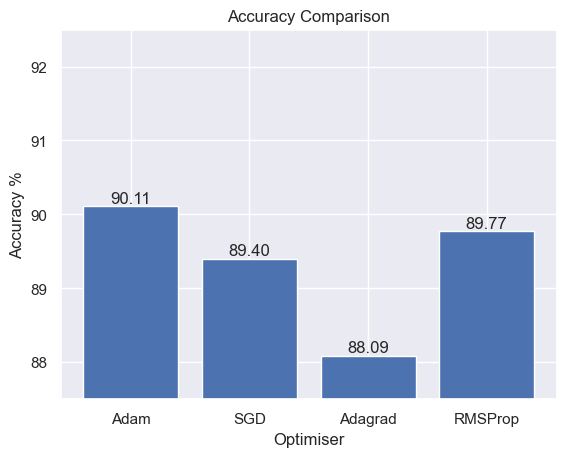

In [36]:
# Test performance comparison
x = ["Adam", "SGD", "Adagrad", "RMSProp"]
accuracy_data = [dropout_test_accuracy,SGD_test_accuracy,adagrad_test_accuracy,RMS_test_accuracy]
barchart = plt.bar(x, accuracy_data)
plt.bar_label(barchart, fmt="{:.2f}")
plt.ylim(87.5, 92.5)
plt.xlabel("Optimiser")
plt.ylabel("Accuracy %")
plt.title("Accuracy Comparison")
plt.show()

## Data Augmentation
Another way we can improve our model performance is through augmentation of our training data. This is by applying random transforms such as flips and rotations to the training data. In theory this would enable us to create a infinite training dataset (up to congrence) but for now we will just apply this once on another copy of our modified ANN. Below is an example of augmented data (the same image we used for comparison earlier).

In [55]:
# Define dataset transforms
augment_transforms = Compose(
    [
        ToTensor(),
        Normalize(0.5, 0.5),
        RandomHorizontalFlip(0.5),
        RandomAffine(degrees=10, translate=(0.1, 0.1)),
    ]
)
train_dataset_aug = datasets.FashionMNIST(
    root="data", 
    train=True, 
    download=True, 
    transform=augment_transforms,
)
# New data split
train_subset_aug, val_subset_aug = random_split(
    train_dataset_aug, [train_size, val_size]
)
# New Loaders
train_loader_augmented = DataLoader(train_subset_aug, batch_size, shuffle=True, pin_memory=True)
val_loader_aug = DataLoader(val_subset_aug, batch_size, shuffle=False, pin_memory=True)

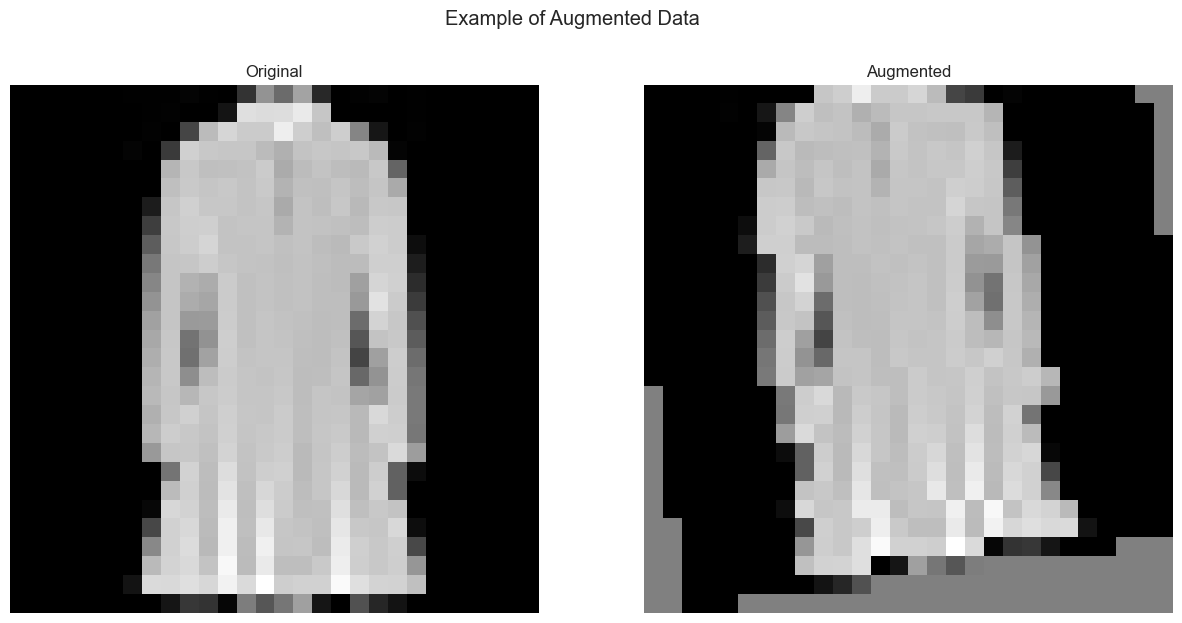

In [25]:
# Examples of augmented data
augment = Compose(
    [RandomHorizontalFlip(1.0), RandomAffine(degrees=10, translate=(0.1, 0.1))]
)
augmented_img = augment(test_image)
fig3, axes3 = plt.subplots(1, 2, figsize=(15, 7))
axes3[0].axis("off")
axes3[1].axis("off")
axes3[0].imshow(test_image.cpu().squeeze(), cmap="gray")
axes3[1].imshow(augmented_img.cpu().squeeze(), cmap="gray")
axes3[0].set_title("Original")
axes3[1].set_title("Augmented")
plt.suptitle("Example of Augmented Data")
plt.show()

In [46]:
ann_aug = MultilayerPerceptron(392, 196, 98, use_dropout=True).to(device)
aug_optimizer = torch.optim.Adam(ann_aug.parameters(), lr=learn_rate)
aug_hist, aug_test_accuracy = run(
    train_loader_augmented,
    val_loader_aug,
    test_loader,
    ann_aug,
    60,
    loss_fn,
    aug_optimizer,
)

Epoch 1/60
Training loss = 0.845971
Validation loss = 0.666059 (Accuracy = 74.99%)
Epoch 2/60
Training loss = 0.685133
Validation loss = 0.592315 (Accuracy = 77.38%)
Epoch 3/60
Training loss = 0.640466
Validation loss = 0.556594 (Accuracy = 79.05%)
Epoch 4/60
Training loss = 0.615960
Validation loss = 0.545710 (Accuracy = 79.14%)
Epoch 5/60
Training loss = 0.593684
Validation loss = 0.524591 (Accuracy = 79.83%)
Epoch 6/60
Training loss = 0.574196
Validation loss = 0.533621 (Accuracy = 79.47%)
Epoch 7/60
Training loss = 0.566956
Validation loss = 0.500520 (Accuracy = 80.66%)
Epoch 8/60
Training loss = 0.554671
Validation loss = 0.493232 (Accuracy = 81.27%)
Epoch 9/60
Training loss = 0.544390
Validation loss = 0.477619 (Accuracy = 81.47%)
Epoch 10/60
Training loss = 0.536871
Validation loss = 0.479453 (Accuracy = 81.91%)
Epoch 11/60
Training loss = 0.527432
Validation loss = 0.467676 (Accuracy = 81.87%)
Epoch 12/60
Training loss = 0.521277
Validation loss = 0.461552 (Accuracy = 82.27%)
E

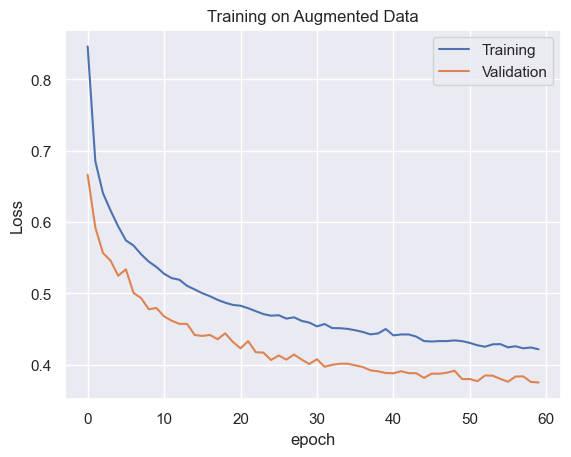

In [49]:
aug_data = PrepareData(aug_hist)
sns.lineplot(data=aug_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=aug_data, x="epoch", y="val_loss", label="Validation")
plt.ylabel('Loss')
plt.title('Training on Augmented Data')
plt.show()

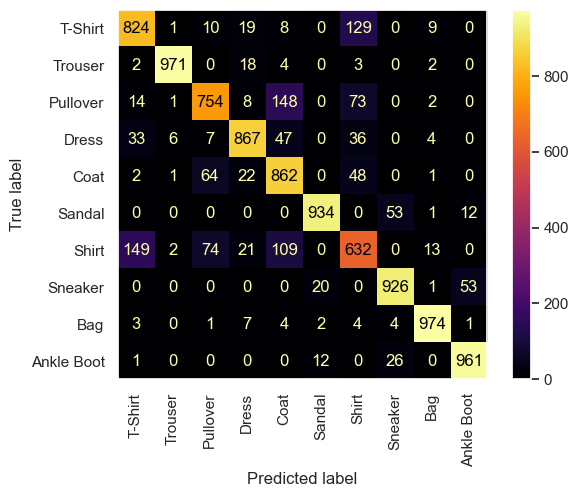

In [50]:
# Visualise confusion matrix
ConfMatDisplay(test_loader, ann_aug)

What is noticable is that our training cycle may need more time, as after 30 epochs we havent seemed to reach any diminishing returns on learning at each step. With that in mind we will further experiment with epoch count.

## CNN Architecture
We now implement our CNN, this will consist of 4 convolutional layers, 2 max pooling layers, a global average pooling layer before a set of 3 dense layers that occur after flattening the image tensor. For each convolution layer we apply zero padding to preserve the size of the tensor, this drastically increases compute cost but it should give us a more accurate model.
Note that we apply our findings from above to add Batch Norm and Dropout layers in our network. We use the Adam as our optimiser as per our findings above and still use log softmax as our activation function.

In [76]:
# Initialise with hyperparameters
cnn = CNNNetwork(in_channels=1, out_channels=10, filters1=128, filters2=256).to(device)
summary(cnn, input_size=(1, 28, 28))
cnn_optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 28, 28]           1,280
       BatchNorm2d-2          [-1, 128, 28, 28]             256
            Conv2d-3          [-1, 128, 28, 28]         147,584
       BatchNorm2d-4          [-1, 128, 28, 28]             256
         MaxPool2d-5          [-1, 128, 14, 14]               0
            Conv2d-6          [-1, 256, 14, 14]         295,168
       BatchNorm2d-7          [-1, 256, 14, 14]             512
            Conv2d-8          [-1, 256, 14, 14]         590,080
       BatchNorm2d-9          [-1, 256, 14, 14]             512
        MaxPool2d-10            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-11            [-1, 256, 1, 1]               0
          Flatten-12                  [-1, 256]               0
           Linear-13                  [-1, 128]          32,896
      BatchNorm1d-14                  [

In [77]:
# Train and test
epochs = 30
cnn_hist, cnn_taccuracy = run(train_loader, val_loader, test_loader, cnn, epochs, loss_fn, cnn_optimizer)

Epoch 1/30
Training loss = 0.724412
Validation loss = 0.428593 (Accuracy = 84.38%)
Epoch 2/30
Training loss = 0.414601
Validation loss = 0.332196 (Accuracy = 87.99%)
Epoch 3/30
Training loss = 0.342830
Validation loss = 0.287636 (Accuracy = 89.40%)
Epoch 4/30
Training loss = 0.297430
Validation loss = 0.256834 (Accuracy = 90.72%)
Epoch 5/30
Training loss = 0.268165
Validation loss = 0.244007 (Accuracy = 91.06%)
Epoch 6/30
Training loss = 0.247535
Validation loss = 0.237332 (Accuracy = 91.20%)
Epoch 7/30
Training loss = 0.232243
Validation loss = 0.230153 (Accuracy = 91.53%)
Epoch 8/30
Training loss = 0.219938
Validation loss = 0.216363 (Accuracy = 91.99%)
Epoch 9/30
Training loss = 0.207073
Validation loss = 0.217655 (Accuracy = 92.18%)
Epoch 10/30
Training loss = 0.198388
Validation loss = 0.202446 (Accuracy = 92.62%)
Epoch 11/30
Training loss = 0.184580
Validation loss = 0.207636 (Accuracy = 92.47%)
Epoch 12/30
Training loss = 0.178295
Validation loss = 0.203027 (Accuracy = 92.77%)
E

## Trying with augmented data (60 epochs)

In [83]:
cnn_aug = CNNNetwork().to(device)
optimizer_cnn_aug = torch.optim.Adam(cnn_aug.parameters(), lr=learn_rate)
epochs = 60
cnn_aug_hist, cnn_aug_test_accuracy = run(train_loader_augmented, val_loader_aug,test_loader,cnn_aug,epochs,loss_fn,optimizer_cnn_aug)

Epoch 1/60
Training loss = 0.902734
Validation loss = 0.606153 (Accuracy = 77.71%)
Epoch 2/60
Training loss = 0.589801
Validation loss = 0.471415 (Accuracy = 83.19%)
Epoch 3/60
Training loss = 0.509103
Validation loss = 0.422563 (Accuracy = 84.28%)
Epoch 4/60
Training loss = 0.460722
Validation loss = 0.426675 (Accuracy = 84.41%)
Epoch 5/60
Training loss = 0.430581
Validation loss = 0.360270 (Accuracy = 86.84%)
Epoch 6/60
Training loss = 0.406439
Validation loss = 0.349531 (Accuracy = 87.25%)
Epoch 7/60
Training loss = 0.390536
Validation loss = 0.334750 (Accuracy = 87.71%)
Epoch 8/60
Training loss = 0.374292
Validation loss = 0.330354 (Accuracy = 87.93%)
Epoch 9/60
Training loss = 0.362667
Validation loss = 0.318621 (Accuracy = 88.49%)
Epoch 10/60
Training loss = 0.352619
Validation loss = 0.312483 (Accuracy = 88.53%)
Epoch 11/60
Training loss = 0.340669
Validation loss = 0.305517 (Accuracy = 88.98%)
Epoch 12/60
Training loss = 0.339320
Validation loss = 0.306885 (Accuracy = 88.78%)
E

## Visualising filters and feature maps
Using the following function we are able to visualise both a sample of the filters and feature maps from our CNN after training, in this case we will call it just for the first layer, but we could feasibly do so for all 4 of the convolutional layers in the network (however this would require me to add compatibility for layer 3 and 4 with the use of an (el)if statement).

In [ ]:
def visualise_filters(layer):
    kernels = layer.weight.data.cpu().numpy()
    fig, axes = plt.subplots(16, 8, figsize=(12, 12))
    for i in range(kernels.shape[0]):
        axes[i // 8, i % 8].imshow(kernels[i, 0], cmap="gray")
        axes[i // 8, i % 8].axis("off")
    plt.show()

def visualise_feature_maps(feature_maps):
    feature_maps = feature_maps.cpu().detach().numpy()
    num_feature_maps = feature_maps.shape[1]
    fig, axes = plt.subplots(16, 8, figsize=(12, 12))
    for i in range(num_feature_maps):
        axes[i // 8, i % 8].imshow(feature_maps[0, i, :, :], cmap="gray")
        axes[i // 8, i % 8].axis("off")
    plt.show()

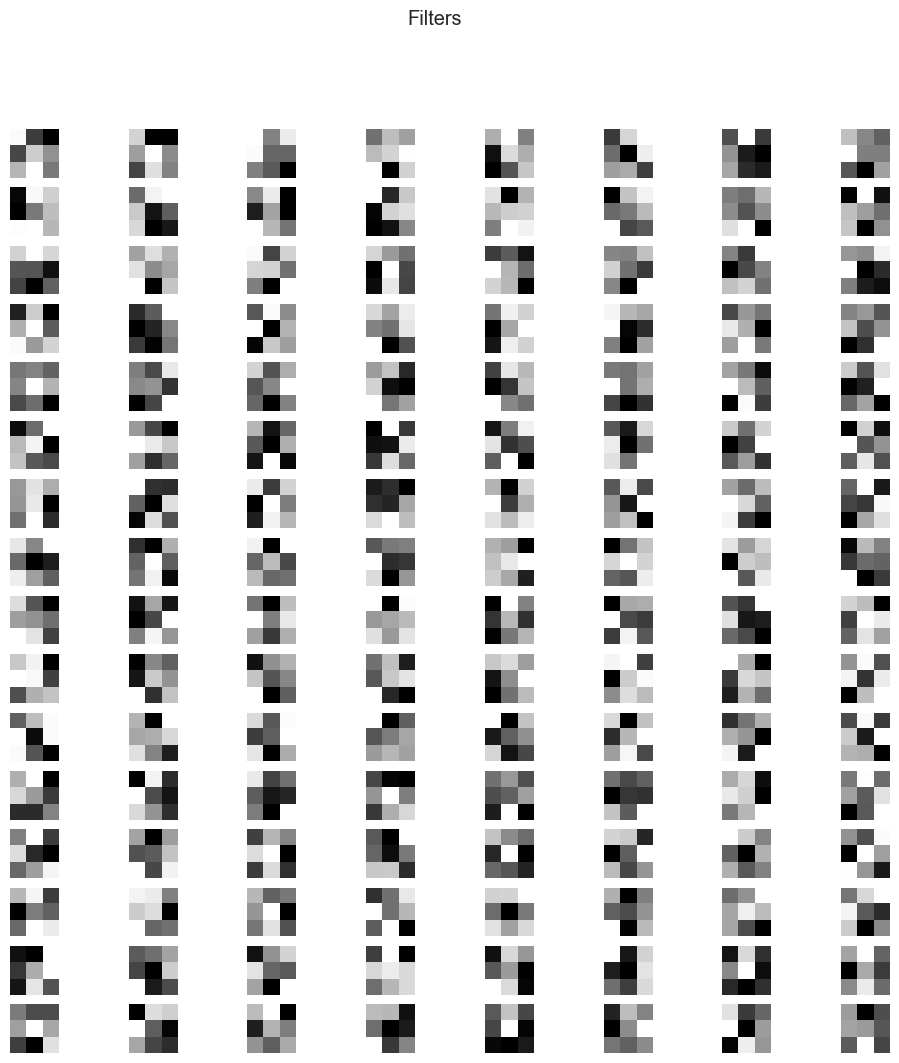

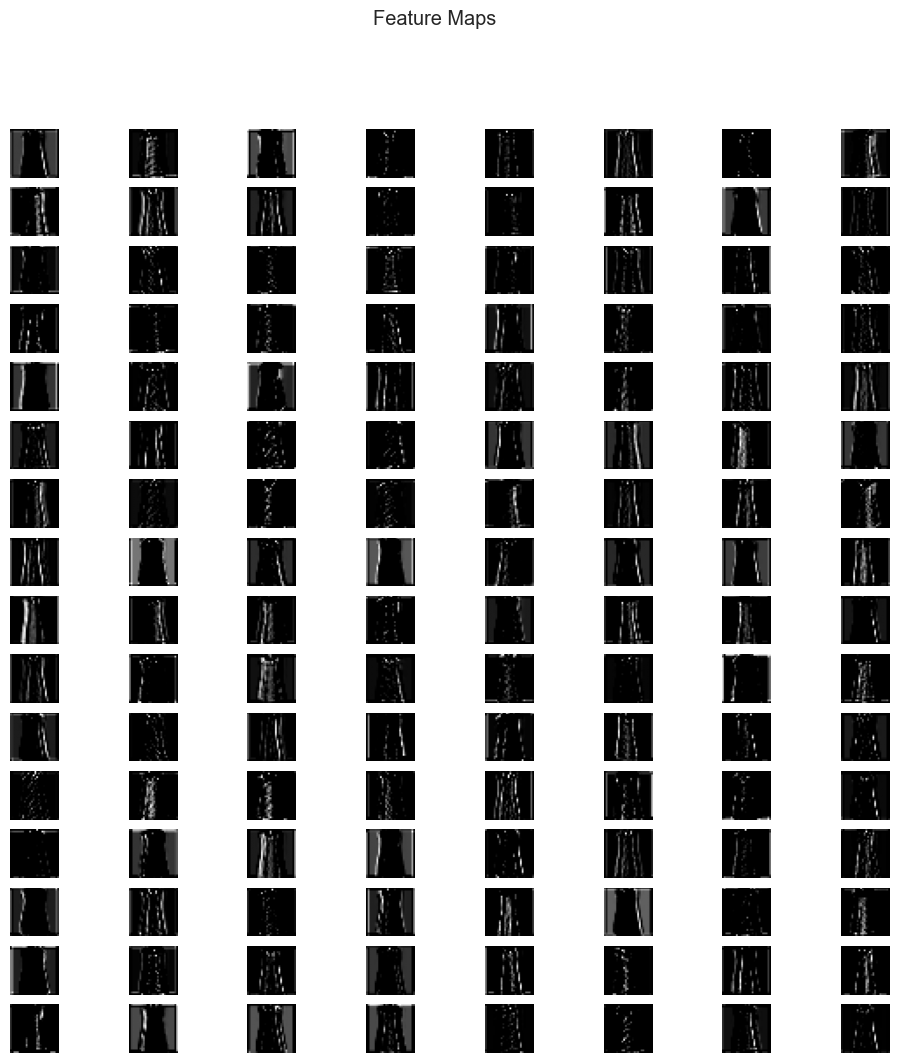

In [78]:
# visualise filters in the first convolution layer
visualise_filters(cnn.conv1)
# visualise the feature maps after 2 convolutions
visualise_feature_maps(cnn.feature_map2)

### Loss evaluation and performance
What is immediately obvious is that a CNN performs better than the ANNs as we are easily able to pass the 90% accuracy breakpoint. However, there is some evidence of overfitting occuring, likely due to a lack of dropout between the convolution layers. As such it may be wise to stop training after around 10 to 15 epochs as the model is likely to perform even better on unseen data after that point.

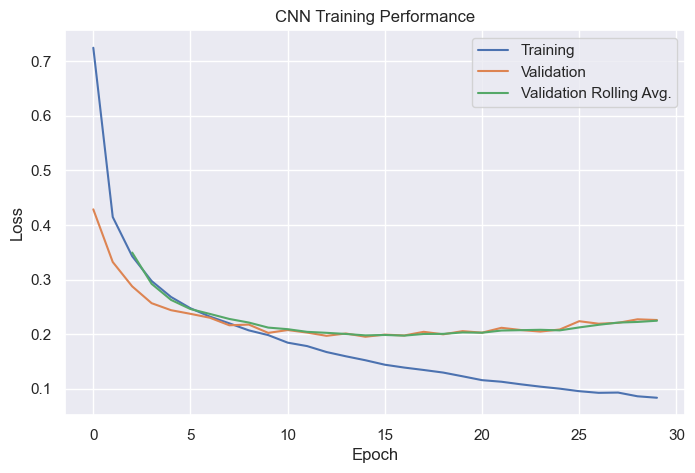

In [84]:
cnn_data = PrepareData(cnn_hist)
cnn_aug_data = PrepareData(cnn_aug_hist)
# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=cnn_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=cnn_data, x="epoch", y="val_loss", label="Validation")
sns.lineplot(data=cnn_data, x="epoch", y="val_rolling", label="Validation Rolling Avg.")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Performance")
plt.show()

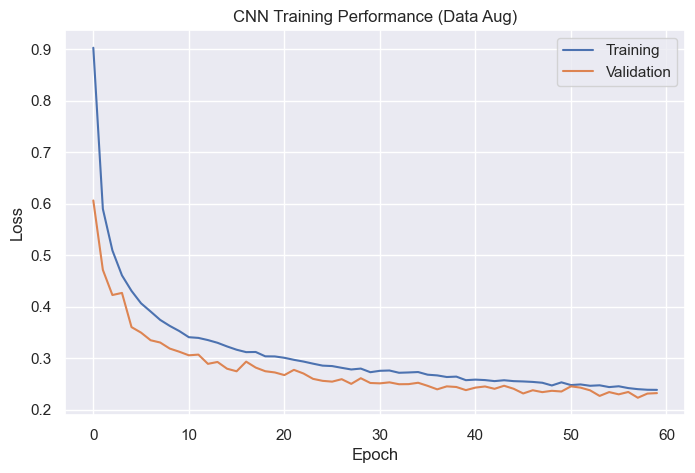

In [91]:
plt.figure(figsize=(8, 5))
sns.lineplot(data=cnn_aug_data, x="epoch", y="train_loss", label="Training")
sns.lineplot(data=cnn_aug_data, x="epoch", y="val_loss", label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training Performance (Data Aug)")
plt.show()

### Confusion Matrix
We can see the CNN is the best perfomer so far, especially with regards to the problematic classification of shirts. There is a clear improvement in precision where we once again see an uplift in the minimum number of correct predictions. This is likely due to a CNN's ability to better store spatial information (by virtue of the structure of a matrix).

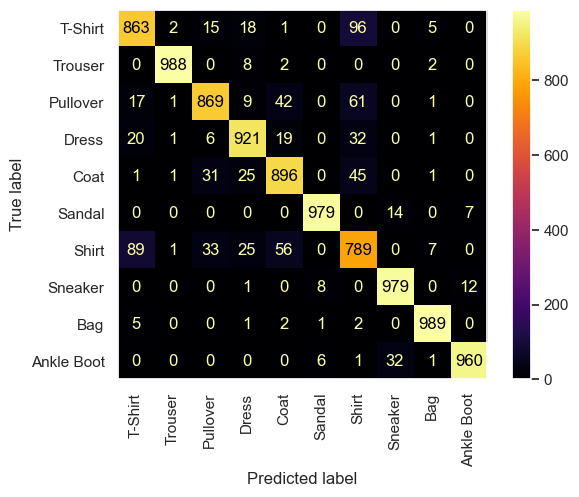

In [ ]:
# Visualise confusion matrix
ConfMatDisplay(test_loader, cnn)
ConfMatDisplay(test_loader,cnn_aug)

### Comparing Model Accuracy
Below is a plot of the models' 5-epoch rolling average accuracy on the validation set in training. I note that there is only a small bump in accuracy when implementing dropout and batch norm in spite of how noticable the improvements to training stability are.

The CNN is very clearly the 'winner' when it comes to classifying test data correctly, scoring around 2-3% better than our modified ANN. Additionally it reaches this point much faster than the ANNs, taking only around 15 epochs to peak in validation accuracy.

The accuracy plot shows quite clearly where overfitting begins to take place as the gradients of our curves begin to reduce or in the case of the CNN even become negative.

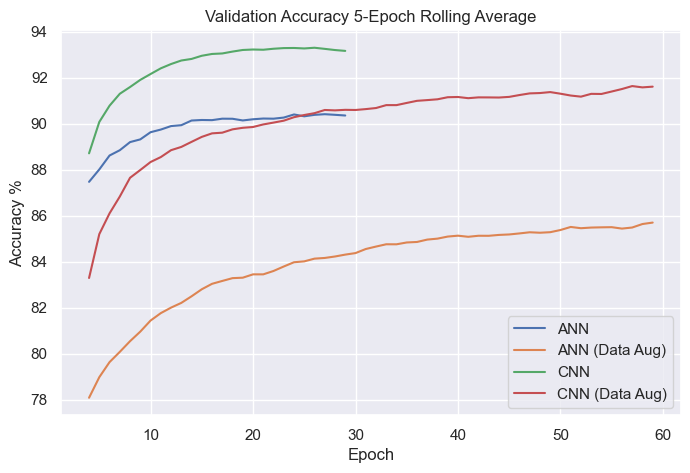

In [90]:
# Comparitive validation accuracy plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=dropout_data, x="epoch", y="acc_rolling", label="ANN")
sns.lineplot(data=aug_data, x="epoch", y="acc_rolling", label="ANN (Data Aug)")
sns.lineplot(data=cnn_data, x="epoch", y="acc_rolling", label="CNN")
sns.lineplot(data=cnn_aug_data,x="epoch",y="acc_rolling", label='CNN (Data Aug)')
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Validation Accuracy 5-Epoch Rolling Average")
plt.show()

## Comparing other metrics
We can also compare the precision, recall and f1 score of our models using our CustomMetrics function. The plot of this really highlights the areas that the models struggle to predict. Clearly 'Shirt' is the most problematic cateogry but we see that the CNN has consistently better results across almost all measures. Note the labels say 'ann' and 'cnn' but this just means the highest performing version of model that we tested in each given category.

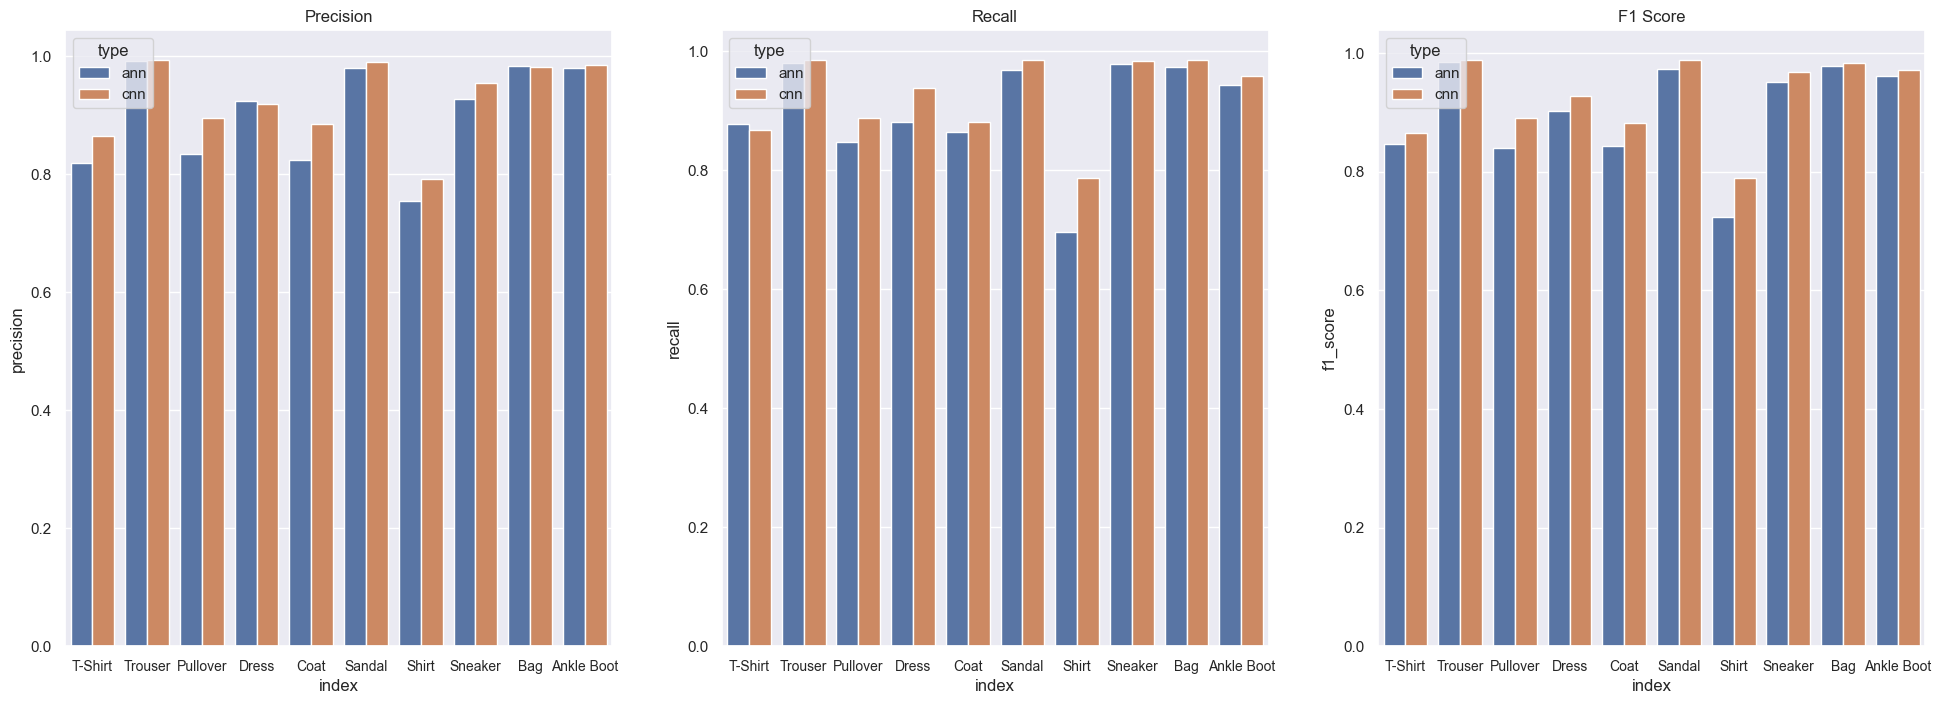

In [ ]:
dropout_metrics = CustomMetrics(test_loader,ann_dropout,type='ann')
cnn_metrics = CustomMetrics(test_loader,cnn,type='cnn')
all_metrics = [dropout_metrics,cnn_metrics]
all_metrics = pd.concat(all_metrics)

fig4, axes4 = plt.subplots(1, 3, figsize=(24,8))
sns.barplot(ax=axes4[0], data=all_metrics, x='index', y='precision',hue='type')
axes4[0].set_xticks(range(10))
axes4[0].set_xticklabels(data_labels, size='small')
axes4[0].set_title('Precision')
sns.barplot(ax=axes4[1], data=all_metrics, x='index', y='recall',hue='type')
axes4[1].set_xticks(range(10))
axes4[1].set_xticklabels(data_labels, size='small')
axes4[1].set_title('Recall')
sns.barplot(ax=axes4[2], data=all_metrics, x='index', y='f1_score',hue='type')
axes4[2].set_xticks(range(10))
axes4[2].set_xticklabels(data_labels, size='small')
axes4[2].set_title('F1 Score')
plt.show()

### Calculating some final averages for use in report

In [115]:
def Meanmetrics(metrics):
    mean_metrics = {'precision':metrics.precision.mean(),
    'recall':metrics.recall.mean(),
    'f1_score':metrics.f1_score.mean(),
    }
    return mean_metrics

cnn_mean_metrics = Meanmetrics(cnn_metrics)
print(cnn_mean_metrics)
dropout_mean_metrics = Meanmetrics(dropout_metrics)
print(dropout_mean_metrics)

ann_metrics=CustomMetrics(test_loader,ann_model,type='ann')
ann_mean_metrics=Meanmetrics(ann_metrics)
print(ann_mean_metrics)

ann_aug_metrics=CustomMetrics(test_loader,ann_aug,type='ann_aug')
aug_mean_metrics = Meanmetrics(ann_aug_metrics)
print(aug_mean_metrics)

cnn_aug_metrics = CustomMetrics(test_loader,cnn_aug,type='cnn_aug')
cnn_aug_mean_metrics = Meanmetrics(cnn_aug_metrics)
print(cnn_aug_mean_metrics)

{'precision': np.float64(0.9258526877402293), 'recall': np.float64(0.9258), 'f1_score': np.float64(0.9257709294970965)}
{'precision': np.float64(0.9015852842364198), 'recall': np.float64(0.9010999999999999), 'f1_score': np.float64(0.9009102135415811)}
{'precision': np.float64(0.8911856805389258), 'recall': np.float64(0.8873999999999999), 'f1_score': np.float64(0.8884810378672128)}
{'precision': np.float64(0.871827019878587), 'recall': np.float64(0.8705), 'f1_score': np.float64(0.8702327544320848)}
{'precision': np.float64(0.9170408523333233), 'recall': np.float64(0.9157), 'f1_score': np.float64(0.9159581355082604)}


## Closing Thoughts
Overall, its quite clear to see the CNN performs far better than the ANNs do. While it comes at a computational cost, the higher accuracy is very noticable especially in the areas that the ANN struggles to predict correctly. If I were to further develop my models and testing methodology, I would want to implement early stopping in a formal way using a patience system, I note that this is very easy to do with tensorflow as there exists a built-in method for doing so. Data augmentation would also be useful for improving testing performance on unseen data. 

Given more time to allow for computation, developing an ensemble network with majority voting could further improve our outcomes as well as combining elements of more advanced network architectures such as GoogLeNet or VisionTransformer, both of which are more advanced CNN architectures.

On reflection it would have been far easier to implement my project using tensorflow and keras, due to the existence of prebuilt train and test cycles amongst other useful methods, however I believe the depth of understanding I have gained as a result of using PyTorch (especially as I have minimal programming experience prior to this: some basic Python for first year maths and a little bit of R for numerical analysis) has helped me to feel much more comfortable with both python and coding in general.

For bibliography and references, please refer to the bibliography contained within the report file (as it is much easier for me to manage this through BibTeX).